In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=14)

In [2]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
expid = 4
globpath = basedir + 'galaxy_sim_catalog/spectra/galaxies/*expid%03d*.fits' % expid

# Don't include galaxies with supernovae
gal_spectra = [fn for fn in glob.glob(globpath) 
                 if not '-with-SN' in os.path.basename(fn)]

print len(gal_spectra), "total spectra"

21000 total spectra


## Read Spectra into Table

In [3]:
spec_table = Table(names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                          'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'),
                 dtype=('S23', 'S4', 'S5', float, 
                        float, float, list, list, list))

for n, spectra in enumerate(gal_spectra):
        
    if "-with-SN" in spectra:
        specid = int(spectra[-20:-15])
    else:
        specid = int(spectra[-10:-5])
    
        
    with fits.open(spectra, memmap=0) as hdul:

        specid  = os.path.basename(spectra)[8:31]
        objtype = hdul[0].header['OBJTYPE']

        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN']
            Z    = hdul[0].header['REDSHIFT']
            mag  = hdul[0].header['MAG']
            wave = hdul[1].data / (Z+1) # shifted to rest frame
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = np.nan
            else:
                flux = hdul[2].data
                sn_epoch = hdul[0].header['SN_EPOCH']
            ivar = hdul[3].data / (1e-17)**2

            new_row = [specid, objtype, has_sn, sn_epoch, 
                       Z, mag, wave, flux, ivar]
            spec_table.add_row(new_row)

In [4]:
spec_table[:1]

ID,OBJTYPE,HAS_SN,SN_EPOCH,REDSHIFT,MAG,WAVE,FLUX,IVAR
str23,str4,str5,float64,float64,float64,object,object,object
20190104-expid004-04671,BGS,False,nan,0.291278719902,19.4860725403,"[ 2764.08175567 2764.85618182 2765.63060796 ..., 7614.31288518 7615.08731133 7615.86173747]","[ -9.27759753e-17 5.60811382e-17 4.15625377e-18 ..., 2.82170365e-17 4.81132647e-17 3.06221369e-17]","[ 4.34122554e+31 1.24758553e+32 1.38400014e+32 ..., 1.14079616e+34 1.01143954e+34 4.80093302e+32]"


In [5]:
len(spec_table)

18900

In [8]:
# Get the wavelength range for which all redshifted spectra overlap
maxmin = 0
minmax = 10000 # something bigger 9800 (Z=0)
for galaxy in spec_table:
    galwave = galaxy['WAVE']
    galwmin = np.min(galwave)
    galwmax = np.max(galwave)
    if maxmin < galwmin:
        maxmin = galwmin
    if minmax > galwmax:
        minmax = galwmax
        
print maxmin, minmax

3533.66777329 7024.48998954


In [9]:
# Define the wavelength range covering the full range of redshifted spectra
allwaves = np.concatenate(spec_table['WAVE'])
min_wave = np.min(allwaves)
max_wave = np.max(allwaves)

print min_wave, max_wave

2549.45077685 9736.29854916


In [10]:
# Define a common wavelength grid to resample all spectra to

step = 1.0 # A
# Full range
# global_wavelength_grid = np.arange(min_wave, max_wave+step, step)

# Sliced common range
global_wavelength_grid = np.arange(maxmin, minmax+step, step)


In [11]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
for spectra in spec_table:
    wave = spectra['WAVE']
    flux = spectra['FLUX']
    ivar = spectra['IVAR']
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, wave, flux,
                             ivar=ivar, extrapolate=False
                            )
    resample_fluxes.append(spec_flux_resample)
    
spec_table['RESAMPLED_FLUX'] = resample_fluxes

In [12]:
spec_table[:1]

ID,OBJTYPE,HAS_SN,SN_EPOCH,REDSHIFT,MAG,WAVE,FLUX,IVAR,RESAMPLED_FLUX [3492]
str23,str4,str5,float64,float64,float64,object,object,object,float64
20190104-expid004-04671,BGS,False,nan,0.291278719902,19.4860725403,"[ 2764.08175567 2764.85618182 2765.63060796 ..., 7614.31288518 7615.08731133 7615.86173747]","[ -9.27759753e-17 5.60811382e-17 4.15625377e-18 ..., 2.82170365e-17 4.81132647e-17 3.06221369e-17]","[ 4.34122554e+31 1.24758553e+32 1.38400014e+32 ..., 1.14079616e+34 1.01143954e+34 4.80093302e+32]",2.9849957822e-17 .. 3.33032437682e-17


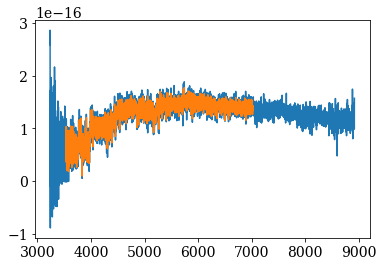

In [13]:
n = 341 # sample
plt.plot(spec_table[n]['WAVE'], spec_table[n]['FLUX'])
plt.plot(global_wavelength_grid, spec_table[n]['RESAMPLED_FLUX'])

In [14]:
data = []
for spec in spec_table:
    data.append(spec['RESAMPLED_FLUX'])

## Eigenspectra Decomposition

In [15]:
galaxies = np.asarray(data)

In [16]:
# There are two methods to do this:
# 1. Eigendecomposition on a correlation (or covarience) matrix
# 2. Singular Value Decomposition on the data matrix itself

# First calculate each normalized specra
normed_galaxies = galaxies / np.linalg.norm(galaxies, axis=1).reshape(-1,1)

In [17]:
# Next define a correlation matrix
C = np.dot(normed_galaxies.T, normed_galaxies)

In [18]:
# Solve the eigenvalue equation v^-1 C v = diag(w)
w, v = np.linalg.eig(C)

In [19]:
# Get the eigenvectors that correspond to the 10 largest eigenvalues
eigenvectors = [evec for ev, evec in sorted(zip(w, v.T))][::-1]

In [20]:
# # Alternatively one can do the SVD
# U, s, V = np.linalg.svd(normed_galaxies)

## Explained variance of the eigenspectra

In [21]:
tot = np.sum(w)
var_exp = [(i / tot)*100 for i in sorted(w, reverse=True)]
cum_var_exp = np.append([0], np.cumsum(var_exp))

In [22]:
print ">90% with", np.argwhere(cum_var_exp > 90)[0][0], "components"
print ">95% with", np.argwhere(cum_var_exp > 95)[0][0], "components"
print ">98% with", np.argwhere(cum_var_exp > 98)[0][0], "components"
print ">99% with", np.argwhere(cum_var_exp > 99)[0][0], "components"

>90% with 1 components
>95% with 1 components
>98% with 2 components
>99% with 3 components


In [46]:
for i in range(1, 6):
    x1 = r"%d & %.2f\%% & " % (i, cum_var_exp[i])
    x2 = r"%d & %.2f\%% & " % (i+5, cum_var_exp[i+5])
    x3 = r"%d & %.2f\%% & " % (i+10, cum_var_exp[i+10])
    x4 = r"%d & %.2f\%% \\" % (i+15, cum_var_exp[i+15])
    print x1 + x2 + x3 + x4

1 & 96.55\% & 6 & 99.46\% & 11 & 99.51\% & 16 & 99.52\% \\
2 & 98.69\% & 7 & 99.47\% & 12 & 99.51\% & 17 & 99.53\% \\
3 & 99.09\% & 8 & 99.49\% & 13 & 99.52\% & 18 & 99.53\% \\
4 & 99.33\% & 9 & 99.50\% & 14 & 99.52\% & 19 & 99.53\% \\
5 & 99.40\% & 10 & 99.50\% & 15 & 99.52\% & 20 & 99.53\% \\


In [22]:
ncomponents = 10 # np.argwhere(cum_var_exp > 98)[0][0]

eigenbasis = np.asarray(eigenvectors[:ncomponents])
# svd_eigenbasis = U[:ncomponents]

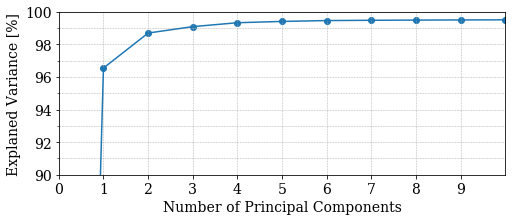

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,3))

ax.plot(range(len(cum_var_exp)), cum_var_exp)
ax.scatter(range(len(cum_var_exp))[1:], cum_var_exp[1:])
# ax.axhline(98, ls='--', color='r', label='98%')
ax.grid(ls='--', lw=.5)
ax.grid(which='minor', ls='--', lw=.5)
ax.set_yticks([91, 93, 95, 97, 99], minor=True)

ax.set(xlim=[0, ncomponents], ylim=[90, 100],
       xticks=range(ncomponents),
       xlabel='Number of Principal Components',
       ylabel='Explaned Variance [%]')

ax.legend(loc='best')
# savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/thesis/Figures/'
# plt.savefig(savedir + 'explained_variance.png',
#             format='png', dpi=300, bbox_inches='tight')

## Plot the eigenspectra

In [24]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n/10%10!=1)*(n%10<4)*n%10::4])

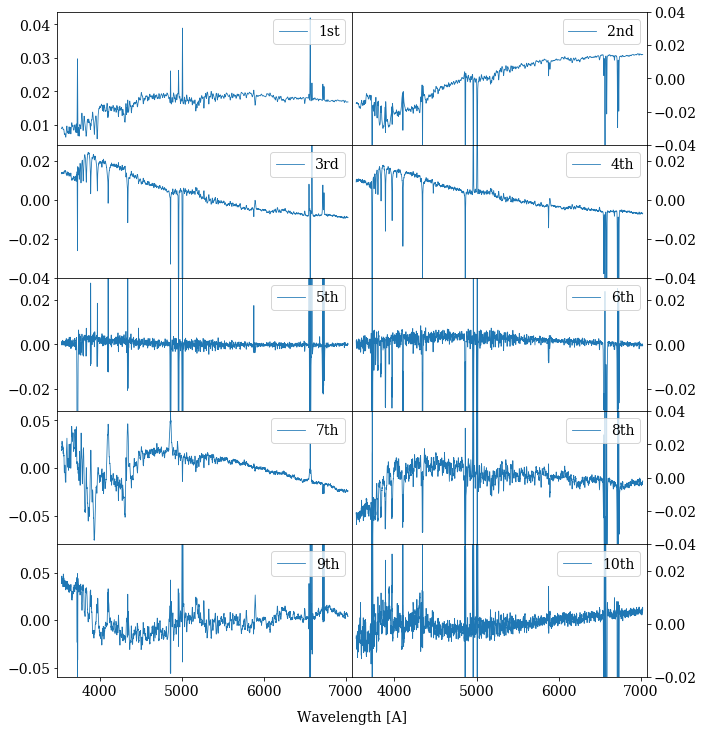

In [25]:
fig, axes = plt.subplots(int(np.ceil(ncomponents/2.)),2, figsize=(10,10),
                         sharex='col')

i=0
for eigenspec, ax in zip(eigenbasis, axes.flatten()):
    i+=1
    if np.median(eigenspec) < 0:
        eigenspec = -eigenspec
    ax.plot(global_wavelength_grid, eigenspec, lw=0.8, 
            label="%s" % ordinal(i))
    if not i%2:
        ax.yaxis.tick_right()
    ax.legend(loc='upper right', fontsize=14)
        
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, 
                    right=None, top=None, 
                    wspace=0, hspace=0)

# Manually set limits
axes[0,1].set_ylim(-0.04, 0.04)
axes[1,0].set_ylim(-0.04, 0.028)
axes[1,1].set_ylim(-0.04, 0.028)
axes[2,0].set_ylim(-0.03, 0.03)
axes[2,1].set_ylim(-0.03, 0.03)
axes[3,0].set_ylim(-0.08, 0.06)
axes[3,1].set_ylim(-0.04, 0.04)
axes[4,0].set_ylim(-0.06, 0.08)
axes[4,1].set_ylim(-0.02, 0.03)

xmin = global_wavelength_grid[0]
xmax = global_wavelength_grid[-1]
axes[0,0].set_xlim(xmin-50, xmax+50)
axes[0,1].set_xlim(xmin-50, xmax+50)

# fig.suptitle('Simulated BGS Eigenspectra', y=1.01)
fig.text(0.5, -0.005, 'Wavelength [A]', ha='center', va='center')

# savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/thesis/Figures/'
# plt.savefig(savedir + 'simulated-BGS-eigenspectra.png',
#             format='png', dpi=300, bbox_inches='tight')

In [26]:
# Write the eigenbasis out
outfile = basedir + 'galaxy_sim_catalog/eigenspectra.txt'
outtable = [global_wavelength_grid]
for eigenspec in eigenbasis:
    outtable.append(eigenspec)
    
np.savetxt(outfile, outtable)

## Project a galaxy onto the basis and plot

In [38]:
n = 1035 # 1035 341 413 test spectrum
spectrum  = spec_table[n]['RESAMPLED_FLUX']

In [39]:
# Project/fit the spectrum and basis
basis_fit = np.dot(np.linalg.pinv(eigenbasis.T), spectrum)
bestfit_spectra = np.dot(basis_fit, eigenbasis)

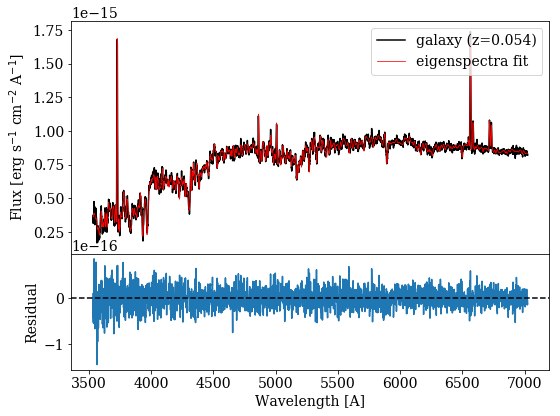

In [40]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6), sharex=True,
                              gridspec_kw = {'height_ratios':[2, 1]})

ax1.plot(global_wavelength_grid, spectrum, lw=1.5, color='k', 
         label='galaxy (z=%.3f)' % spec_table['REDSHIFT'][n])
ax1.plot(global_wavelength_grid, bestfit_spectra, 
         lw=.75, color='r', label='eigenspectra fit')
ax1.legend(loc='upper right', fontsize=14)
ax1.set(ylabel=r'Flux [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')

ax2.plot(global_wavelength_grid, spectrum - bestfit_spectra, 
#          label='residual'
        )
ax2.axhline(0, color='k', ls='--')
ax2.legend(loc='upper right', fontsize=14)

ax2.set(xlabel='Wavelength [A]',
        ylabel='Residual')
fig.tight_layout()
plt.subplots_adjust(hspace=0)

# savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/thesis/Figures/'
# plt.savefig(savedir + 'galaxy_eigenspectra_fit.png',
#             format='png', dpi=300, bbox_inches='tight')

### Try with SN host galaxies

In [30]:
# Read in galaxies with 
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
expid = 4
sn_globpath = basedir + 'galaxy_sim_catalog/spectra/bright_atpeak/*expid%03d*.fits' % expid

sn_host_spectra = [fn for fn in glob.glob(sn_globpath) 
                 if '-with-SN' in os.path.basename(fn)]

print len(sn_host_spectra), "total spectra"

18900 total spectra


In [31]:
sn_host_table = Table(names=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                          'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'),
                 dtype=('S23', 'S4', 'S5', float, 
                        float, float, list, list, list))

for n, spectra in enumerate(sn_host_spectra[:100]):
        
    if "-with-SN" in spectra:
        specid = int(spectra[-20:-15])
    else:
        specid = int(spectra[-10:-5])
    
        
    with fits.open(spectra, memmap=0) as hdul:

        specid  = os.path.basename(spectra)[8:31]
        objtype = hdul[0].header['OBJTYPE']

        if objtype in ['SKY', 'FSTD']:
            continue
        else:
            has_sn  = hdul[0].header['HAS_SN']
            Z    = hdul[0].header['REDSHIFT']
            mag  = hdul[0].header['MAG']
            wave = hdul[1].data / (Z+1) # shifted to rest frame
            if not has_sn:
                flux = hdul[2].data * 1e-17 # gal fluxes aren't in units
                sn_epoch = np.nan
            else:
                flux = hdul[2].data
                sn_epoch = hdul[0].header['SN_EPOCH']
            ivar = hdul[3].data / (1e-17)**2

            new_row = [specid, objtype, has_sn, sn_epoch, 
                       Z, mag, wave, flux, ivar]
            sn_host_table.add_row(new_row)

In [32]:
# Resample spectra to a common wavelength grid
resample_fluxes = []
for spectra in sn_host_table:
    wave = spectra['WAVE']
    flux = spectra['FLUX']
    ivar = spectra['IVAR']
    spec_flux_resample, spec_ivar_resample = resample_flux(
                             global_wavelength_grid, wave, flux,
                             ivar=ivar, extrapolate=False
                            )
    resample_fluxes.append(spec_flux_resample)
    
sn_host_table['RESAMPLED_FLUX'] = resample_fluxes

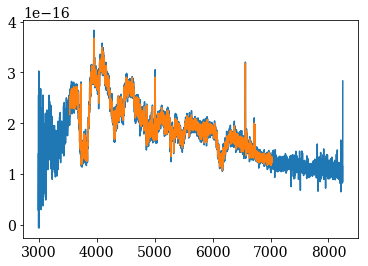

In [33]:
n = 16 # 16 45 190 test spectrum
resampled_spectrum  = sn_host_table[n]['RESAMPLED_FLUX']

wave      = sn_host_table[n]['WAVE']
spectrum  = sn_host_table[n]['FLUX']

plt.plot(wave, spectrum)
plt.plot(global_wavelength_grid, resampled_spectrum)

In [34]:
# Project/fit the spectrum and basis
basis_fit = np.dot(np.linalg.pinv(eigenbasis.T), resampled_spectrum)
bestfit_spectra = np.dot(basis_fit, eigenbasis)

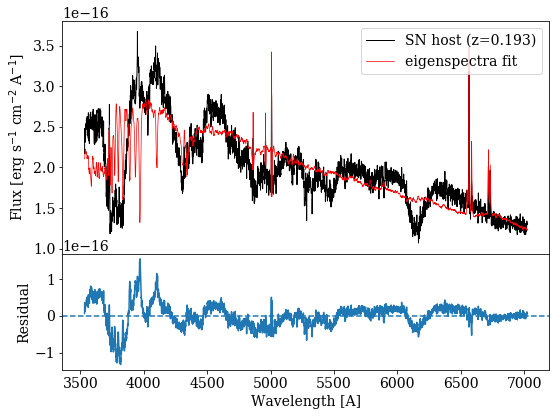

In [36]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,6), sharex=True,
                              gridspec_kw = {'height_ratios':[2, 1]})

ax1.plot(global_wavelength_grid, resampled_spectrum, lw=1, color='k', 
         label='SN host (z=%.3f)' % sn_host_table['REDSHIFT'][n])
ax1.plot(global_wavelength_grid, bestfit_spectra, 
         lw=.7, color='r', label='eigenspectra fit')
ax1.legend(loc='upper right', fontsize=14)
ax1.set(ylabel=r'Flux [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$]')

ax2.plot(global_wavelength_grid, resampled_spectrum - bestfit_spectra, 
#          label='residual'
        )
ax2.axhline(0, ls='--')
ax2.legend(loc='upper right', fontsize=14)

ax2.set(xlabel='Wavelength [A]',
        ylabel='Residual')
fig.tight_layout()
plt.subplots_adjust(hspace=0)

# savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/thesis/Figures/'
# plt.savefig(savedir + 'snhost_eigenspectra_fit.png',
#             format='png', dpi=300, bbox_inches='tight')